In [ ]:
#Student Name: Liguangxuan He
#Student ID: 1006141809
#Instructor Name: Prof. Shion Guha
#Course Code: INF2178
#Course Name: Experimental Design for Data Science
#Program: Master of Information
#Faculty: Faculty of Information
#School: University of Toronto

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [70]:
#load packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
!pip install pingouin
import pingouin as pg
import scipy.stats as stats
import seaborn as sns
from scipy.stats import shapiro
from statsmodels.formula.api import mixedlm
from scipy.stats import levene
from statsmodels.stats.power import TTestIndPower

In [13]:
#read csv from drive
file_path = '/content/drive/MyDrive/Inf2178 Assignment/Technical 4/INF2178_A4_data.csv'
df = pd.read_csv(file_path)
#display the first 6 rows
df.head(6)

,Unnamed: 0,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444
5,6,OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,F,R,90,18,3.0,27.0,0.0,1200,0.718,1.462


Columns Meaning:


*   Subject ID: Subject Identification
*   MRI ID: Magnetic Resonance Imaging Exam Identification
*   Group: Class (Nondemented不痴呆的, Demented痴呆的, Converted)
*   Visit: Visit Order
*   MR Delay: magnetic resonance (MR) Delay Time (Contrast), the delay time that is prior to the image procurement
*   M/F: Gender
*   Hand: Dominant Hand
*   Age: Age in years
*   EDUC: Educational Level, years f education
*   SES: Socioecnomic Status
*   MMSE: Mini Mental State Examination
*   CDR: Clinical Dementia Rating
*   eTIV: Estimated Total Intracranial Volume
*   nWBV: Normalize Whole Brain Volume
*   ASF: Atlas Scale Factor, volume scaling factor for brain size


In [14]:
#check basic information about the data such as column names, data types, non-null counts.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  294 non-null    int64  
 1   Subject ID  294 non-null    object 
 2   MRI ID      294 non-null    object 
 3   Group       294 non-null    object 
 4   Visit       294 non-null    int64  
 5   MR Delay    294 non-null    int64  
 6   M/F         294 non-null    object 
 7   Hand        294 non-null    object 
 8   Age         294 non-null    int64  
 9   EDUC        294 non-null    int64  
 10  SES         279 non-null    float64
 11  MMSE        293 non-null    float64
 12  CDR         294 non-null    float64
 13  eTIV        294 non-null    int64  
 14  nWBV        294 non-null    float64
 15  ASF         294 non-null    float64
dtypes: float64(5), int64(6), object(5)
memory usage: 36.9+ KB
None


Cleaning the data:  


1.   Remove 'Unnamed: 0' column
2.   Handling missing values
3.   Convert categorical columns to 'category' dtype if needed


In [15]:
#1.Remove 'Unnamed: 0' column
df.drop(columns=['Unnamed: 0'], inplace = True)

#2.Handling missing values
#for SES, fill missing values with the mean
df['SES'].fillna(df['SES'].mean(), inplace=True)
#for MMSE, fill missing values with the mean
df['MMSE'].fillna(df['MMSE'].mean(), inplace=True)

#3.Convert categorical columns to 'categpry' dtype
df['Group'] = df['Group'].astype('category')
df['M/F'] = df['M/F'].astype('category')
df['Hand'] = df['Hand'].astype('category')

In [17]:
#display category counts for the following columns
columns_of_interest = ['Group', 'M/F', 'Hand'] # these are already object datatype columns
#check categories for each column
for column in columns_of_interest:
    print(f"Column: {column}")
    print(df[column].value_counts())
    print("\n")

Column: Group
Nondemented    142
Demented       126
Converted       26
Name: Group, dtype: int64


Column: M/F
F    173
M    121
Name: M/F, dtype: int64


Column: Hand
R    294
Name: Hand, dtype: int64




In [18]:
#get info about descriptive states for numerical columns
round(df.describe(),2)

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,294.00,294.00,294.00,294.00,294.00,294.00,294.00,294.00,294.00,294.00
mean,1.49,349.79,76.41,14.56,2.49,27.26,0.30,1478.85,0.73,1.20
std,0.50,400.74,7.61,2.88,1.10,3.41,0.38,176.56,0.04,0.14
min,1.00,0.00,60.00,6.00,1.00,15.00,0.00,1106.00,0.65,0.88
25%,1.00,0.00,71.00,12.00,2.00,26.00,0.00,1347.25,0.70,1.12
50%,1.00,0.00,76.00,14.50,2.00,29.00,0.00,1461.50,0.73,1.20
75%,2.00,671.50,81.00,16.00,3.00,30.00,0.50,1569.00,0.76,1.30
max,2.00,1707.00,98.00,23.00,5.00,30.00,2.00,2004.00,0.84,1.59


**Exploratory data analysis (EDA)**  

1.   What are the stength and direction of relatioships among quantitative features such as age, education, socioeconomic status, mental state examination socres, dementia rating, and brain volumne metrics?
2.   How do pairs of features distribute and correlate with each other across different dementia statuses?
3.   How do educational level, socioeconomic status (SES), Mini-Mental State Examination (MMSE) scores, and Clinical Demential Ratinf (CDR) scores vary across different dementia statuses (nondemented, demented, coverted)?
4.   In addition, Are there significant differences in brain volume metrics (eTIV and nWBV) and Atlas Scale Factor (ASF) across dementia statuses?
5. How does age vary across different dementia statuses, and does gender influence age distribution within these groups?




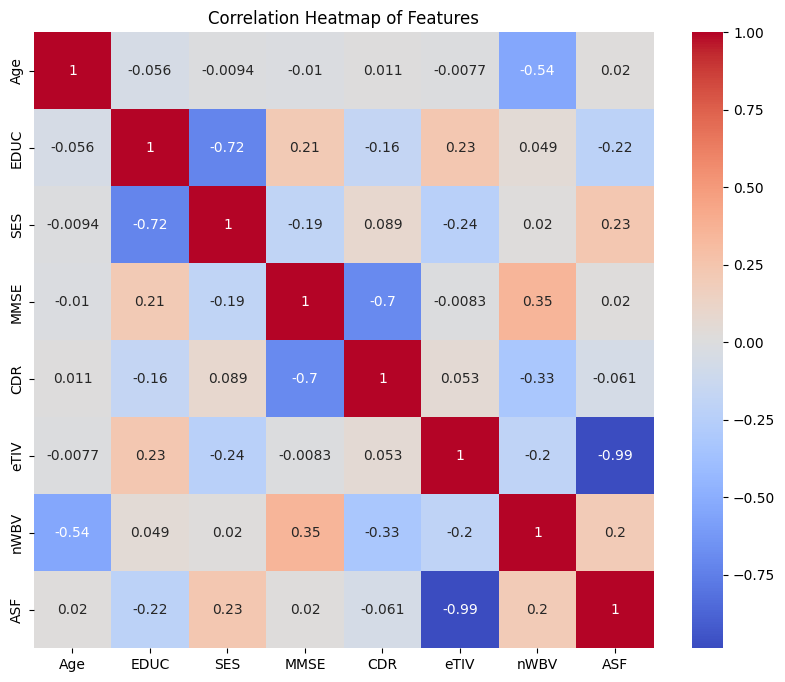

In [20]:
#1. What are the stength and direction of relatioships among quantitative features such as age, education, socioeconomic status, mental state examination socres, dementia rating, and brain volumne metrics?
#heatmap of correlations among quantitatice features
plt.figure(figsize=(10, 8))
correlation_matrix = df[['Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.show()


This heatmap provides a visual representation of the correlation coefficients between different quantitative features, helping to quickly identify strong or weak relationships and potentially guiding further analysis on these relationships.

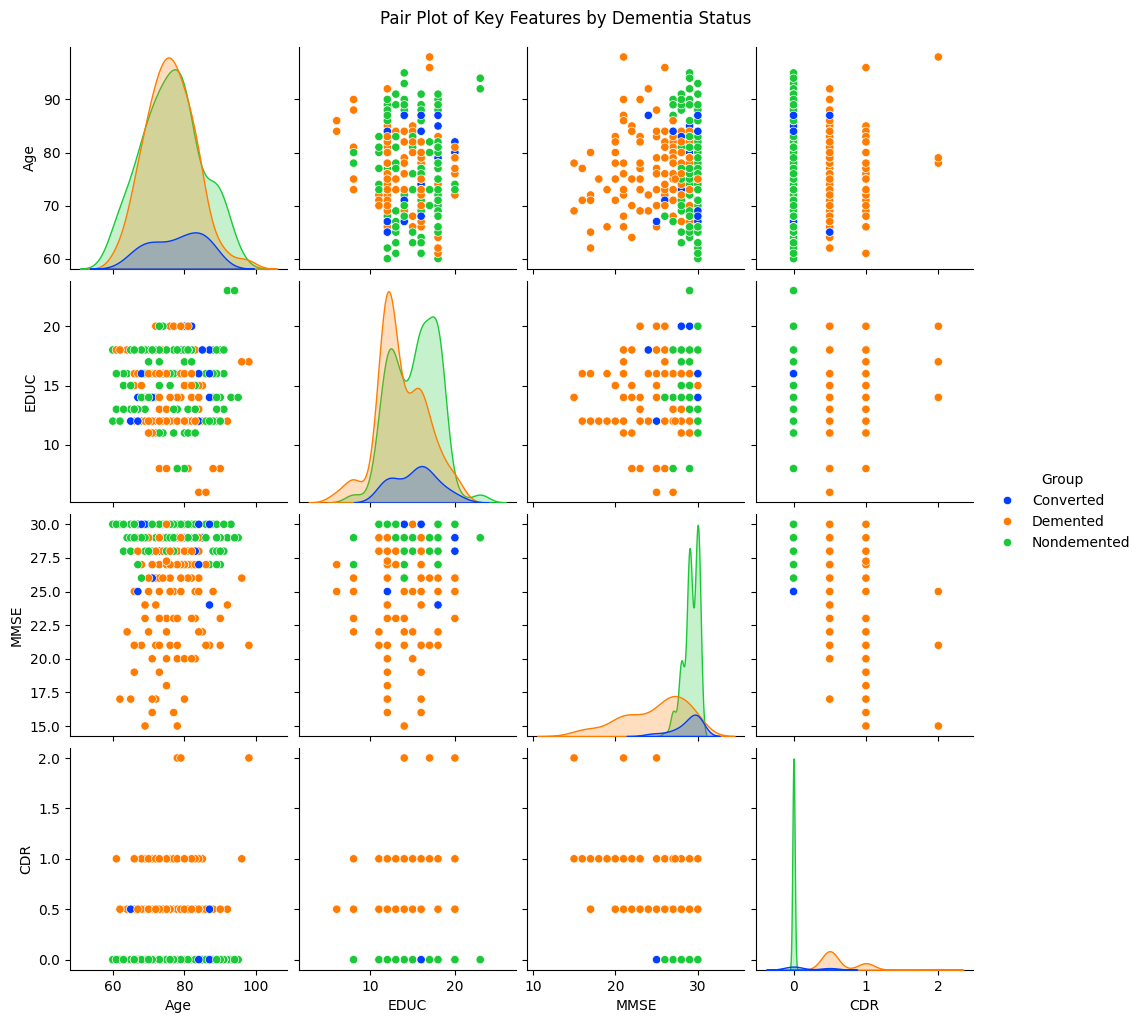

In [23]:
#2.How do pairs of features distribute and correlate with each other across different dementia statuses?
#pair plot of key features by dementia status
sns.pairplot(df[['Age', 'EDUC', 'MMSE', 'CDR', 'Group']], hue='Group', palette='bright')
plt.suptitle('Pair Plot of Key Features by Dementia Status', y=1.02)
plt.show()

A pair plot allows for the examination of the distribution of individual variables and the pairwise relationships between them, segmented by dementia status. This can reveal differences in distributions and relationships for nondemented, demented, and converted groups.

<ipython-input-33-55efb0dfafd3>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-33-55efb0dfafd3>:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-33-55efb0dfafd3>:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-33-55efb0dfafd3>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-33-55efb0dfafd3>:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and wi

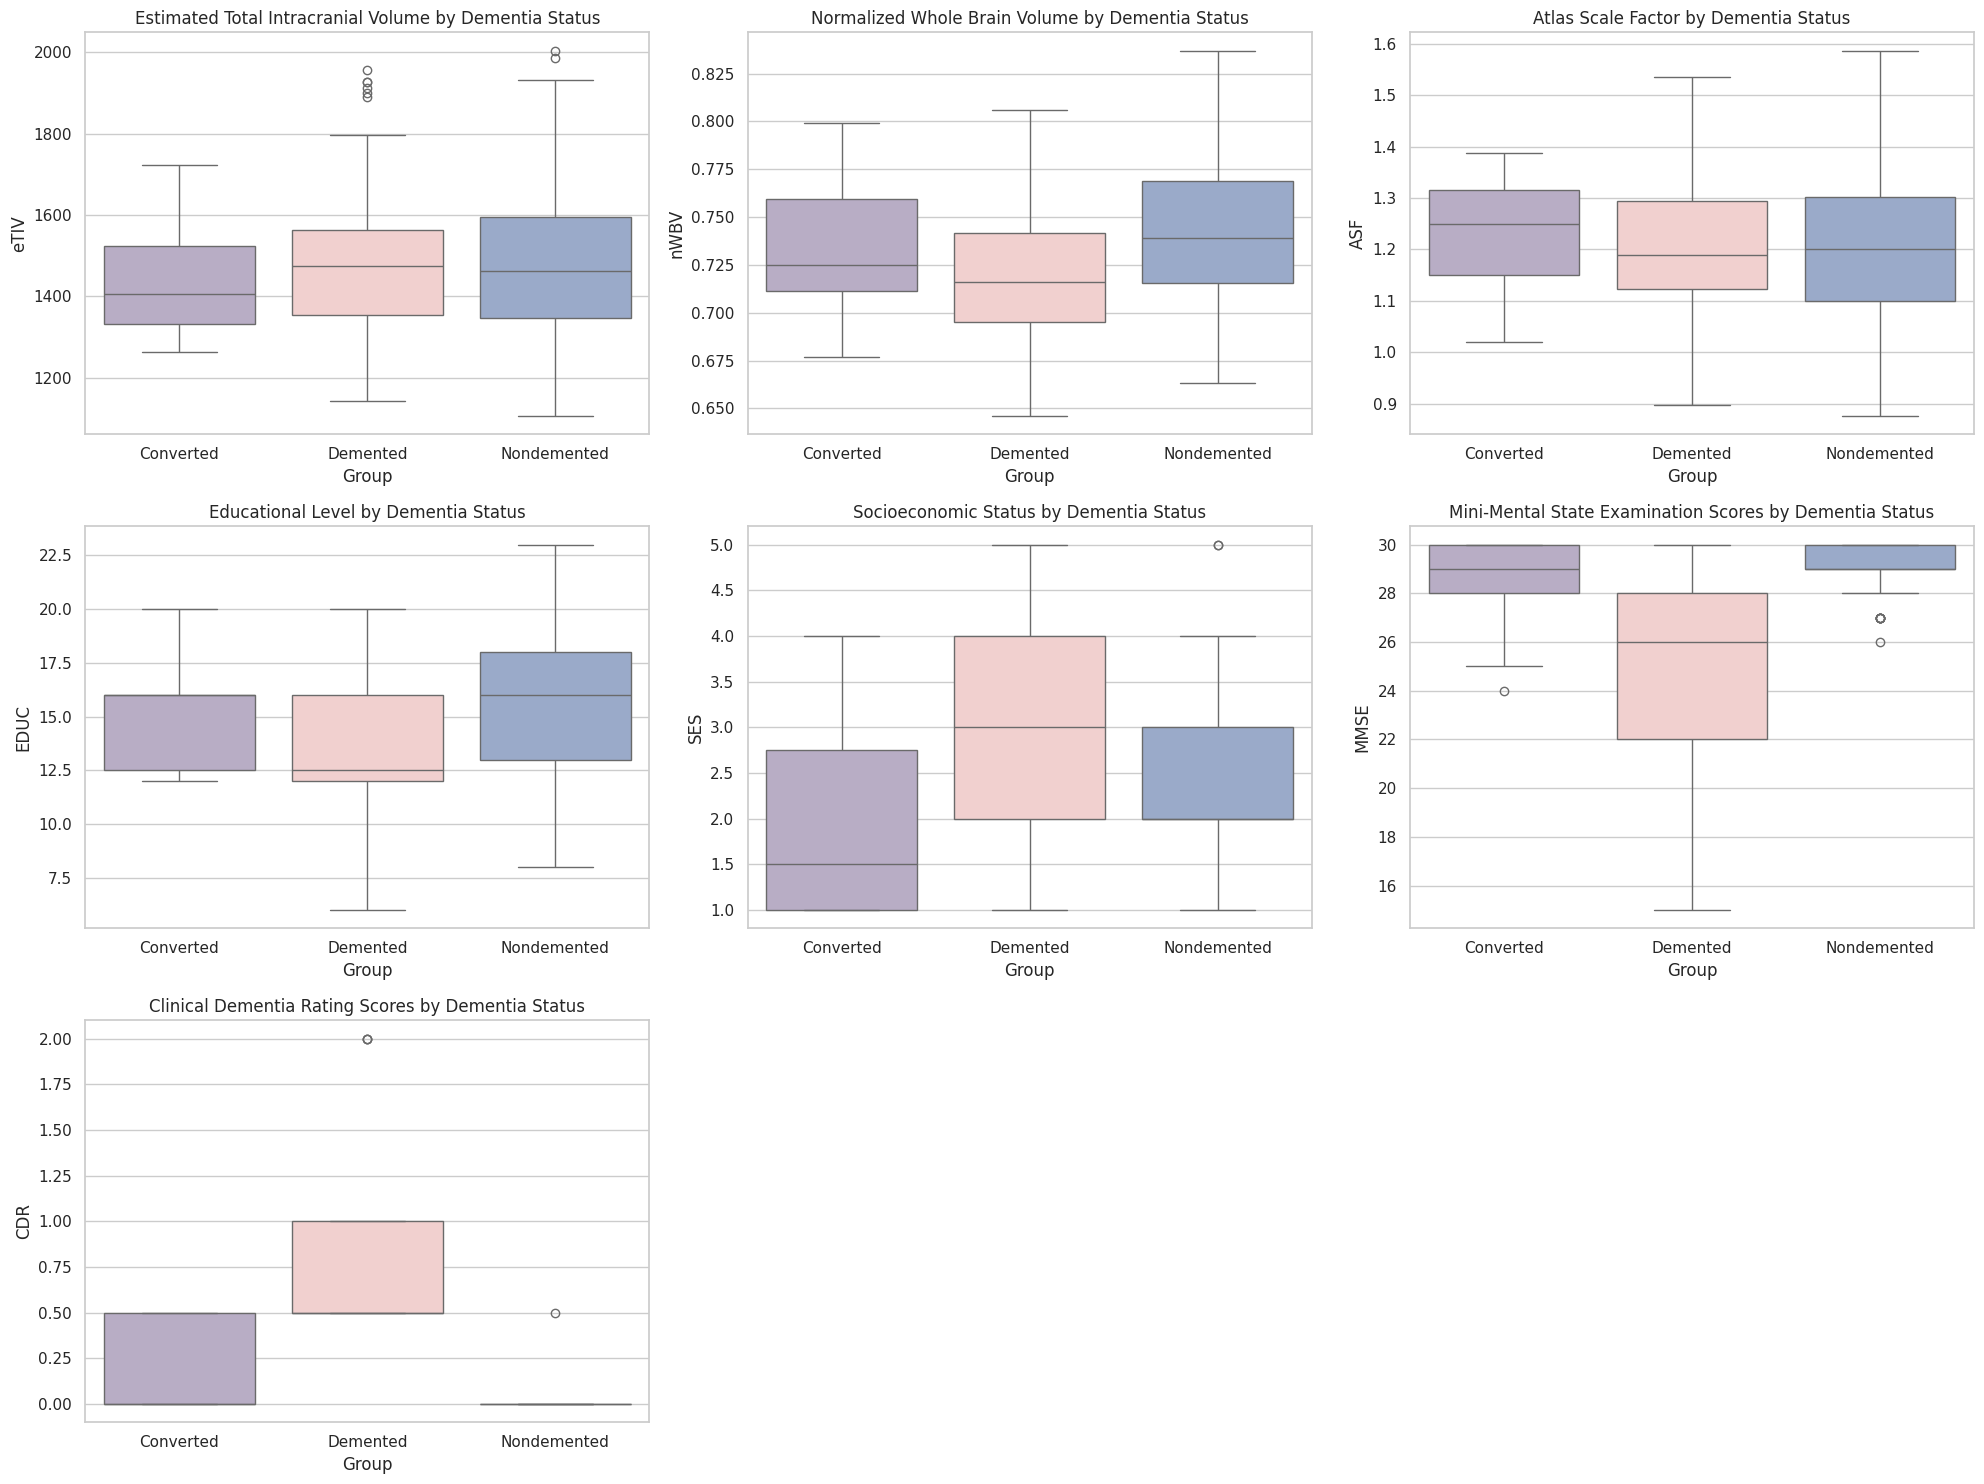

In [33]:
#3.How do educational level, socioeconomic status (SES), Mini-Mental State Examination (MMSE) scores, and Clinical Demential Ratinf (CDR) scores vary across different dementia statuses (nondemented, demented, coverted)?
# and 4. In addition, Are there significant differences in brain volume metrics (eTIV and nWBV) and Atlas Scale Factor (ASF) across dementia statuses?
#boxplpots of different numerical columns distribution by dementia status
# define a color palette
custom_palette = {'Nondemented': '#92a8d1',  #light blue
                  'Demented': '#f7cac9',    #light pink
                  'Converted': '#b8a9c9'}   #light purple

#setting up the figure for a 3x3 grid
fig, axs = plt.subplots(3, 3, figsize=(20, 15))

#plotting with the custom pastel palette and ensuring consistency across plots
sns.boxplot(x='Group', y='eTIV', data=df, ax=axs[0, 0], palette=custom_palette)
axs[0, 0].set_title('Estimated Total Intracranial Volume by Dementia Status')

sns.boxplot(x='Group', y='nWBV', data=df, ax=axs[0, 1], palette=custom_palette)
axs[0, 1].set_title('Normalized Whole Brain Volume by Dementia Status')

sns.boxplot(x='Group', y='ASF', data=df, ax=axs[0, 2], palette=custom_palette)
axs[0, 2].set_title('Atlas Scale Factor by Dementia Status')

sns.boxplot(x='Group', y='EDUC', data=df, ax=axs[1, 0], palette=custom_palette)
axs[1, 0].set_title('Educational Level by Dementia Status')

sns.boxplot(x='Group', y='SES', data=df, ax=axs[1, 1], palette=custom_palette)
axs[1, 1].set_title('Socioeconomic Status by Dementia Status')

sns.boxplot(x='Group', y='MMSE', data=df, ax=axs[1, 2], palette=custom_palette)
axs[1, 2].set_title('Mini-Mental State Examination Scores by Dementia Status')

sns.boxplot(x='Group', y='CDR', data=df, ax=axs[2, 0], palette=custom_palette)
axs[2, 0].set_title('Clinical Dementia Rating Scores by Dementia Status')

#hiding the unused subplots for a cleaner look
for ax in [axs[2, 1], axs[2, 2]]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Age Distribution by Dementia Status and Gender')

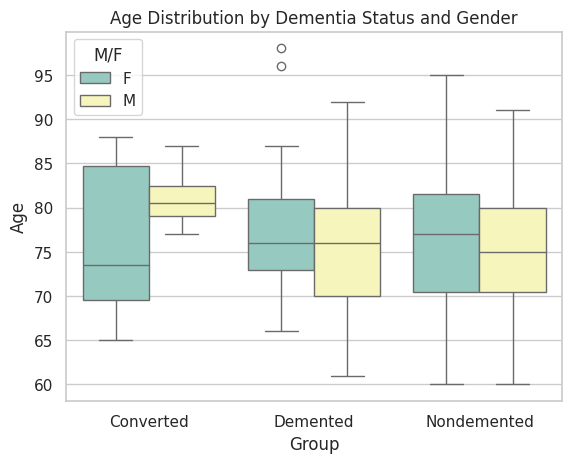

In [30]:
#5.How does age vary across different dementia statuses, and does gender influence age distribution within these groups?
#boxplot of age distribution by dementia status and gender
#setting up the style of the plots
sns.set_style("whitegrid")

#age Distribution by Dementia Status and Gender
sns.boxplot(x='Group', y='Age', hue='M/F', data=df, palette='Set3')
plt.title('Age Distribution by Dementia Status and Gender')

**Mixed-effects ANOVA analysis (Within- and between- subjects)**

Research Question: How do Mini-Mental State Examination (MMSE) scores change over multiple visits within individuals, and does this change differ by dementia status (nondemented, demented, convertes)?  


In [39]:
#1a)within-subject ANOVA with between-subject factor
#compute the two-way mixed-design ANOVA
aov = pg.mixed_anova(dv='MMSE', within ='Visit', between='Group', subject='Subject ID', data=df)
#print above anova summary
pg.print_table(aov)


ANOVA SUMMARY

Source             SS    DF1    DF2       MS       F    p-unc    np2      eps
-----------  --------  -----  -----  -------  ------  -------  -----  -------
Group        1322.017      2    141  661.009  56.100    0.000  0.443  nan
Visit          21.528      1    141   21.528   8.525    0.004  0.057    1.000
Interaction    16.204      2    141    8.102   3.208    0.043  0.044  nan



In [42]:
#1b)post hoc: paired t-test
posthocs = pg.pairwise_ttests(dv='MMSE', within ='Visit', between='Group', subject='Subject ID', data=df)
pg.print_table(posthocs)

/usr/local/lib/python3.10/dist-packages/pingouin/pairwise.py:28: UserWarning:

pairwise_ttests is deprecated, use pairwise_tests instead.




POST HOC TESTS

Contrast       Visit    A            B          Paired    Parametric         T      dof  alternative      p-unc                BF10    hedges
-------------  -------  -----------  ---------  --------  ------------  ------  -------  -------------  -------  ------------------  --------
Visit          -        1            2          True      True           2.876  143.000  two-sided        0.005               4.793     0.159
Group          -        Nondemented  Demented   False     True           9.512   65.514  two-sided        0.000  33060000000000.000     1.745
Group          -        Nondemented  Converted  False     True           1.303   12.315  two-sided        0.216               0.599     0.584
Group          -        Demented     Converted  False     True          -6.745   50.480  two-sided        0.000         2189000.000    -1.164
Visit * Group  1        Nondemented  Demented   False     True           9.124   68.185  two-sided        0.000   3993000000000.000

In [53]:
#1c)assumption check - normality of residuals
# testing normality of MMSE scores within each Visit and Group
for group in df['Group'].unique():
    for visit in df['Visit'].unique():
        data = df[(df['Group'] == group) & (df['Visit'] == visit)]['MMSE']
        stat, p = stats.shapiro(data)
        print(f'Group: {group}, Visit: {visit}, Shapiro-Wilk test: stat={stat}, p={p}')

#define the model
model = mixedlm("MMSE ~ C(Visit) * C(Group)", data=df, groups=df["Subject ID"], re_formula="~C(Visit)")
#fit the model, and display the model summary
result = model.fit()
print(result.summary())

Group: Nondemented, Visit: 1, Shapiro-Wilk test: stat=0.7982513904571533, p=1.5398718744563666e-08
Group: Nondemented, Visit: 2, Shapiro-Wilk test: stat=0.8052802681922913, p=3.312041130243415e-08
Group: Demented, Visit: 1, Shapiro-Wilk test: stat=0.948788046836853, p=0.009978835470974445
Group: Demented, Visit: 2, Shapiro-Wilk test: stat=0.9010415077209473, p=0.00011199634172953665
Group: Converted, Visit: 1, Shapiro-Wilk test: stat=0.7304324507713318, p=0.000777733395807445
Group: Converted, Visit: 2, Shapiro-Wilk test: stat=0.8761541843414307, p=0.07826245576143265
                     Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         MMSE     
No. Observations:          294             Method:                     REML     
No. Groups:                150             Scale:                      1.6323   
Min. group size:           1               Log-Likelihood:             -653.3183
Max. group size:           2              

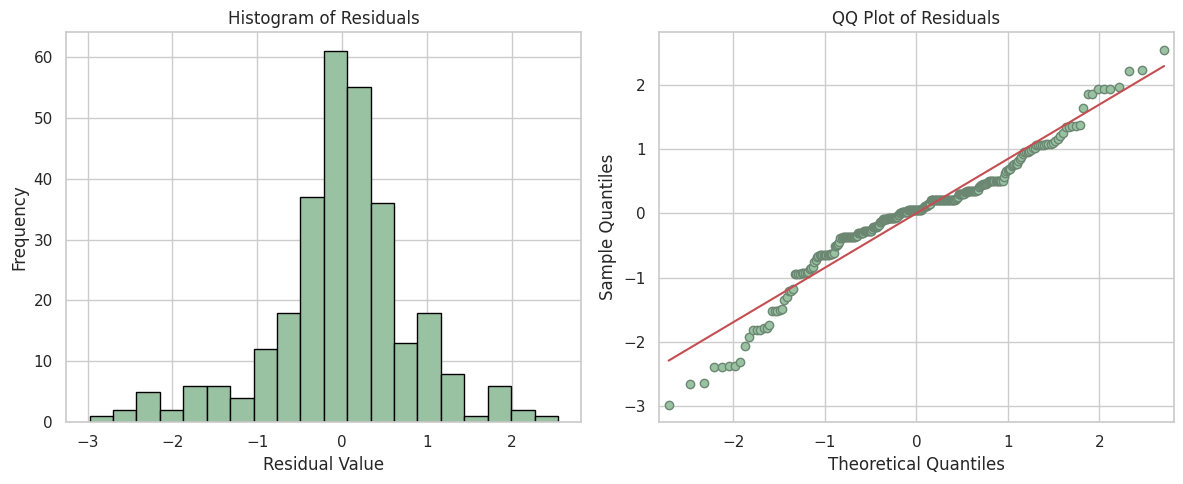

In [55]:
#1c)assumption check - normality of residuals - visualization
#define the residual
residuals = result.resid

#setting up the figure
plt.figure(figsize=(12, 5))

#histogram of residuals
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=20, edgecolor='black', color='#99c2a2')
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')

#QQ plot
plt.subplot(1, 2, 2)
sm.qqplot(residuals, line='s', ax=plt.gca(), markerfacecolor='#99c2a2', markeredgecolor='#6b8771')
plt.title('QQ Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

#adjust layout and display the plots
plt.tight_layout()
plt.show()

In [58]:
#1d)assumption check - homogeneity of variances
#Levene's test(for not normally distributed samples)
df['residuals'] = residuals

#preparing data for Levene's test: grouping residuals by 'Group'
groups = df.groupby('Group')['residuals'].apply(list)

#extracting the groups' residuals into a list of arrays suitable for Levene's test
grouped_residuals = [group for group in groups]

#performing Levene's test
stat, p = levene(*grouped_residuals)
print(f"Levene's test for homogeneity of variances: Statistic={stat}, p-value={p}")

Levene's test for homogeneity of variances: Statistic=41.5164677332683, p-value=1.3741917942819506e-16


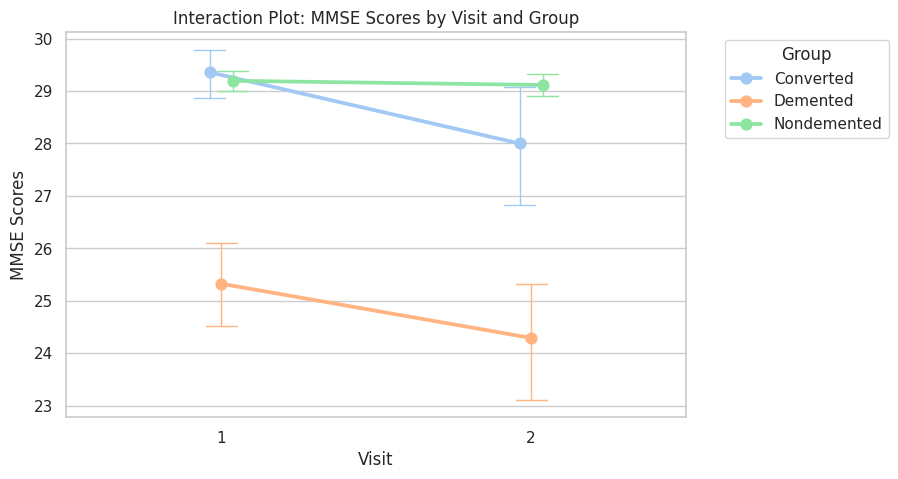

In [64]:
#1e)interaction plot
#setting the style of the plots
sns.set_style("whitegrid")

#create the interaction plot
plt.figure(figsize=(8, 5))
sns.pointplot(data=df, x='Visit', y='MMSE', hue='Group', dodge=True, capsize=.1, err_kws={'linewidth': 1}, palette='pastel')

#adding plot title and labels
plt.title('Interaction Plot: MMSE Scores by Visit and Group')
plt.xlabel('Visit')
plt.ylabel('MMSE Scores')

#show legend
plt.legend(title='Group',bbox_to_anchor=(1.05, 1), loc='upper left')
#display the plot
plt.show()


**Statistical power for t-tests**

In [68]:
#parameters for power analysis
effect_size = 0.7  #as required
alpha = 0.05  #as required
nobs = 50 #number of observation, random chosen
power = 0.91  #as required

#initialize the power analysis object
analysis = TTestIndPower()

#calculate the power
power = analysis.power(effect_size=effect_size, nobs1=nobs, alpha=alpha, ratio=1, alternative='two-sided')
print(f"Power: {power:.3f}")

Power: 0.934


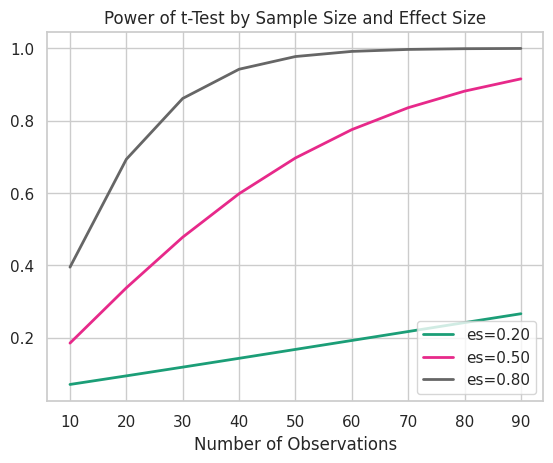

In [75]:
#power curves
#range of sample sizes
sample_sizes = np.arange(10, 100, 10)

#calculate power curve
analysis = TTestIndPower()
power_curve = analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=np.array([0.2, 0.5, 0.8]), alpha=0.05)
plt.title('Power of t-Test by Sample Size and Effect Size')
plt.show()